In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import requests
import skimage
import shutil
import torch
import json
import cv2
import re

from pathlib import Path
from collections import Counter
from tqdm.auto import trange, tqdm
from torchvision import datasets, models, transforms

In [11]:
!git clone https://github.com/facebookresearch/fastText.git
%cd fastText
!pip install .
%cd -
import fasttext

Cloning into 'fastText'...
remote: Enumerating objects: 3854, done.
remote: Total 3854 (delta 0), reused 0 (delta 0), pack-reused 3854
Receiving objects: 100% (3854/3854), 8.22 MiB | 26.24 MiB/s, done.
Resolving deltas: 100% (2417/2417), done.
/content/fastText
Processing /content/fastText
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Using cached pybind11-2.7.1-py2.py3-none-any.whl (200 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3091414 sha256=097e060fb8b7c1d1f0f9f7c2a974620c51ad85122e9e2baa53699ac8bb8f4fe8
  Stored in directory: /tmp/pip-ephem-wheel-cache-i37ai79u/wheels/22/04/6e/b3aba25c1a5

The approach for individual text classification is going to be based on an **I) unsupervised** first step and then a **II) supervised** step.

- I) First, we try to find an word embeddind corpus that well fits with our test data. This is to be done in order to be able to better clusterize the categories on the desired categories.
<br>The approach chosen is based on the **Continuous bag of words** contextual encoder, where we first tokenize each word using an *embedding vector* of size 300, and then we try to optimize those vectors so that we can use a window of words in a sentence to predict one word inside that sentence.


- II) Second, we use the learnt word embeddings (that represents priors on out test dataset) as a startpoint for an standard supervised learning approach using the same model. One important aspect here is that we're training/classifying agains a totally different set of labels(categories), constructed from the dataset **fashion-product-images-small** because we don't  have labels for the test dataset. So, we're going to use an intermediate step to predict the final categories.

# Data processing

In [2]:
import re

def normalize_text(t):
    without_tags = re.sub(r"<.*?>|\[.*?\]|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});|\t|\n", " ", t)
    word_list = without_tags.strip().lower().split()
    without_stop_words = " ".join(word_list)
    return without_stop_words

## Load Test Data

In [3]:
test_categories = pd.read_csv("https://raw.githubusercontent.com/chenlh0/product-classification-challenge/master/product_categories.txt", header=None, index_col=None)[0]
test_products_df = pd.read_json("https://raw.githubusercontent.com/chenlh0/product-classification-challenge/master/product_data.json")

test_categories = test_categories.apply(normalize_text)
test_products_df["description"] = test_products_df["description"].apply(normalize_text)
test_products_df["description"].to_csv("test.txt", header=False, index=False)

## Load Train data

In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [5]:
import kaggle

kaggle.api.authenticate()
kaggle.api.dataset_download_file('paramaggarwal/fashion-product-images-small', "styles.csv", path='./train_val_dataset/', force=True)

train_val_products_df = pd.read_csv("./train_val_dataset/styles.csv.zip", error_bad_lines=False)

train_val_products_df = train_val_products_df\
    .get(["productDisplayName", "subCategory", "id"])\
    .rename(columns={"productDisplayName": "description", "subCategory": "category"})\
    .set_index("id")

train_val_products_df = train_val_products_df[train_val_products_df["description"].notna()] 

train_val_products_df["description"] = train_val_products_df["description"].apply(normalize_text)
train_val_products_df["category"] = train_val_products_df["category"].apply(normalize_text)

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

## Prepare text data

In [21]:
label_to_id = dict(zip(*list(zip(*enumerate(sorted(train_val_products_df["category"].unique()))))[-1::-1]))

In [7]:
def _create_train_data(category_description):
    category, description = category_description
    return f"__label__{label_to_id[category]} {description}"

categories = train_val_products_df['category']
descriptions = train_val_products_df['description']

train_val_products_df["text_data"] = list(map(_create_train_data, zip(categories, descriptions)))

# Train / Val Split

In [8]:
VALIDATION_PROPORTION = 0.15

val_ids = train_val_products_df.groupby("category").sample(frac=VALIDATION_PROPORTION).index

train_val_products_df.loc[val_ids, "text_data"].to_csv("validation.txt", header=False, index=False)
train_val_products_df.loc[~train_val_products_df.index.isin(val_ids), "text_data"].to_csv("train.txt", header=False, index=False)

# I) Training a unsupervised model and tuning it on a supervised task

Training unsupervised using a **Continuous bag of words** (CBOW)

- The model tries to infer a word from all the words in a surrounding window.

- We do that so that the model can have the word embedding priors of the targeted dataset.

In [12]:
model = fasttext.train_unsupervised("test.txt", "cbow", dim=300, epoch=30, lr=0.1)

Below, we can visually check whether or not some structure was learnt after unsupervisedly train our model with CBOW.

The goal here is just to create some structure/prior that could help with detecting the true labels latter.


In [13]:
from sklearn.decomposition import PCA

def _break_line(string, n_words=5):
    return '\n'.join(re.findall('.{1,20}', string[:30]))

def plot_embedding_space(model):
    sentences = test_products_df["description"]
    sentence_embeddings = np.stack([model.get_sentence_vector(s) for s in sentences])
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(sentence_embeddings)

    idxs = np.random.randint(len(principal_components), size=700)
    _, ax = plt.subplots(figsize=(18, 15))
    plt.title("2 Principal components of embedded sentences (formed by )")
    ax.scatter(principal_components[idxs, 0], principal_components[idxs, 1])
    for i in idxs[:10]:
        ax.annotate(_break_line(sentences[i]), 
                    (principal_components[i, 0], principal_components[i, 1]), weight="bold")
    plt.grid()

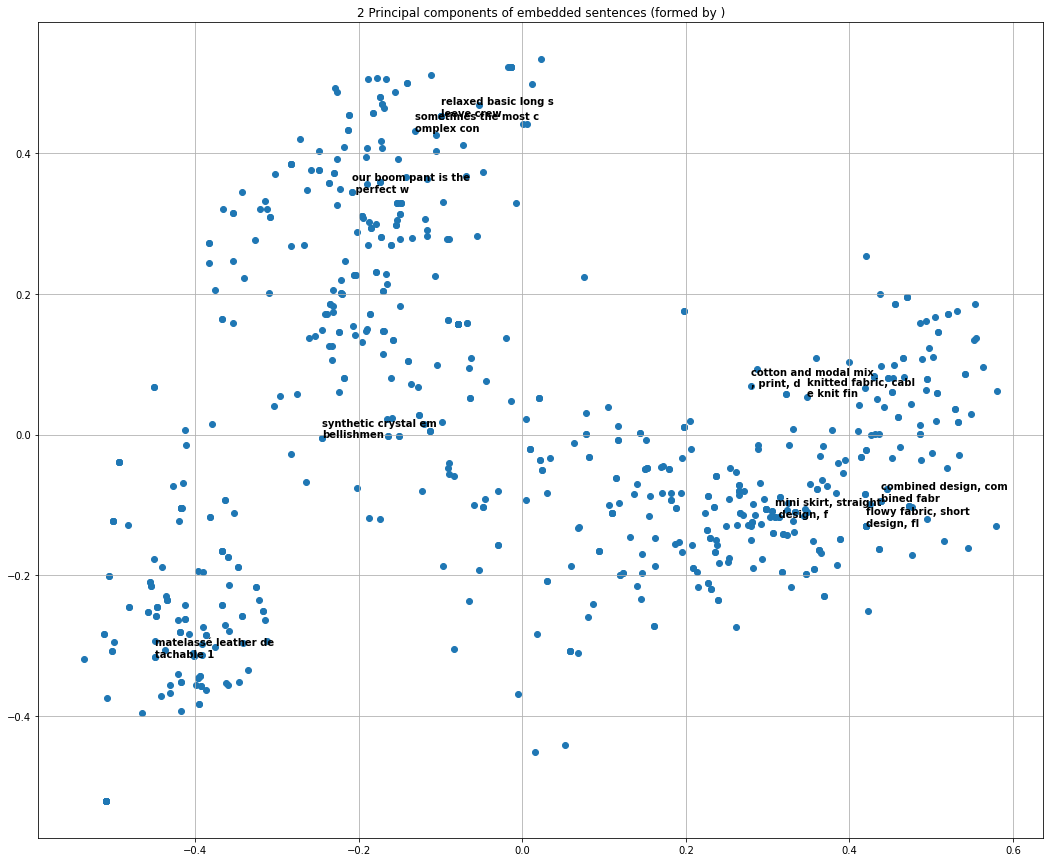

In [14]:
plot_embedding_space(model)

# II) Supervised training

Now, we save the word embeddings obtained from unsupervisedly training on the test data (no leakage, give that we  don't have labels)

In [15]:
words = model.get_words()
word_embeddings = [np.insert(model.get_word_vector(word).astype(object), 0, word, axis=0) for word in words]

pd.DataFrame(word_embeddings)\
  .to_csv("word_embeddings", 
          header=[f"{len(words)}", f"{model.get_dimension()}"] + [None]*299, # the header follows a format defined by fasttext api
          index=None, sep=" ")

And then, training the model using the previously saved word_embeddings priors, we can still see a well structure embedding space on the test set.

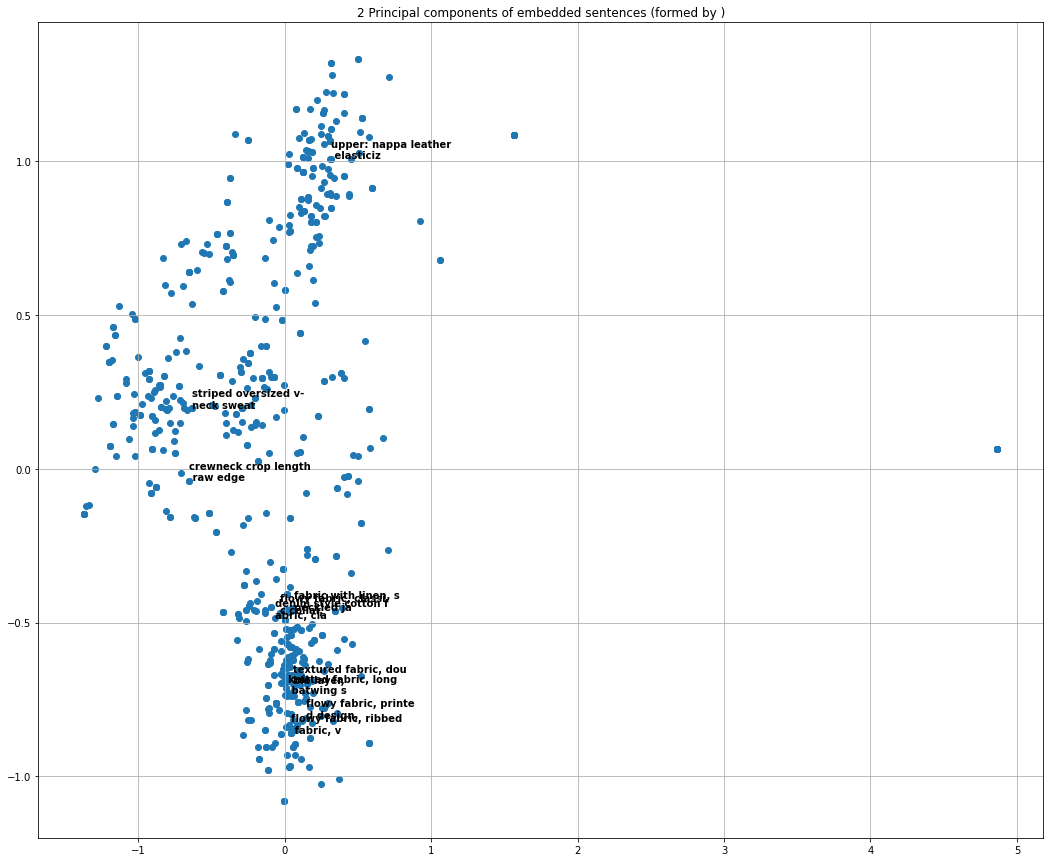

In [16]:
model = fasttext.train_supervised(
    input="train.txt", 
    wordNgrams=2, 
    dim=300, 
    pretrainedVectors="word_embeddings")

plot_embedding_space(model)

In [17]:
metrics = model.test("validation.txt")
print(f"sanity check for overfit:\nprecision {metrics[1]}, recall {metrics[2]}")

sanity check for overfit:
precision 0.9816899294612037, recall 0.9816899294612037


In [18]:
model.predict("leather bag")

(('__label__2',), array([0.99024647]))

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

model.save_model("/content/gdrive/MyDrive/text_categorization.bin")

Mounted at /content/gdrive
